In [1]:
import time
import json
import ast
import os
import datetime
import io
from collections import defaultdict
from tqdm import tqdm

import imageio
import boto3
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
from dl.config.label_map_helper import LabelMapHelper, LabelConversion
import json
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)
import seaborn as sns

from brtdevkit.core.db.athena import AthenaClient
from brtdevkit.data import Dataset
from timezonefinder import TimezoneFinderL
import pytz
import cv2
from brtdevkit.util.aws.s3 import S3
client = S3()

from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import imageids_to_dataset
from aletheia_dataset_creator.config.dataset_config import LEFT_CAMERAS, ALL_CAMERA_PAIRS_LIST
%matplotlib inline

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
pd.set_option('display.max_rows', 500)
athena = AthenaClient()
s3 = boto3.resource('s3')
tf = TimezoneFinderL()
from pathlib import Path
home = Path(os.path.expanduser('~'))
data_path = home / 'data' 

In [3]:
with open('/mnt/sandbox1/alex.li/set3_image_ids.csv', 'r') as f:
    imids = f.readline().split(',')
print(len(imids))

61977


In [4]:
# 1245 human
# 12515 vehicle
data_dir = "/data/jupiter/datasets/vehicles_driving_in_dust/"
df = pd.read_csv(data_dir + '/64dfb36ebe1e14d37b7287d8_master_annotations.csv')

/tmp/ipykernel_20861/4024400960.py:4: DtypeWarning: Columns (34,74,172) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_dir + '/64dfb36ebe1e14d37b7287d8_master_annotations.csv')


In [5]:
# # 716
# # 5893
# data_dir="/data/jupiter/li.yu/data/Jupiter_2023_may_loamy731_vehicle_dust_human_stereo/"
# path =data_dir + "/master_annotations.csv"
# df_unlabled_1 = pd.read_csv(path)

# # 533
# # 6622
# data_dir="/data/jupiter/li.yu/data/Jupiter_2023_may_loamy731_vehicle_dust_human_stereo_part2/"
# path =data_dir + "/master_annotations.csv"
# df_unlabled_2 = pd.read_csv(path)
# df_unlabled = pd.concat([df_unlabled_1, df_unlabled_2])

In [6]:
helper = LabelMapHelper("/home/alex.li/git/JupiterCVML/europa/base/src/europa/dl/config/label_maps/four_class_train.csv")
lc = LabelConversion(helper)

In [7]:
def has_thing(row):
    label = np.load(os.path.join(data_dir, row.rectified_label_save_path))['left']
    label = lc.convert_label_for_driveable_terrain(
        label,
        json.loads(row['label_map']))
    if 'rear' in row['camera_location']:
        has_vehicle = np.sum(label == helper.get_vehicle_label()) > 30
        has_human = np.sum(label == helper.get_human_label()) > 30
    else:
        has_vehicle = np.sum(label == helper.get_vehicle_label()) > 100
        has_human = np.sum(label == helper.get_human_label()) > 100
    return [has_human, has_vehicle]

In [8]:
# df[['has_human', 'has_vehicle']] 
result= df.parallel_apply(has_thing, axis=1, result_type='expand')
# df.loc[:, ['has_human', 'has_vehicle']] = df[['has_human']]

In [ ]:
print(sum(result[0])) # has human
print(sum(result[1])) # has vehicle

NameError: name 'result' is not defined

In [9]:
from typing import List
import logging
from datetime import timedelta

def get_runs(df: pd.DataFrame, trim: bool=True) -> List[pd.DataFrame]:
    """Split all consecutive videos of a dataframe 
    Returns the minimal list of dataframes such that no two dataframes have
    images within 5 seconds of each other
    
    If trim is true, then we do not consider images with no ground truth stop
    detected when selecting the start/end times for the videos, which may
    result in some removed data.
    """
    df['collected_on_dt'] = pd.to_datetime(df.collected_on)
    df = df.sort_values('collected_on_dt')
    if trim:
        # merged_runs = df[result[1]]
        merged_runs = df[result[1]]

    else:
        merged_runs = df
    if len(merged_runs) == 0:
        logging.error("Did not find any runs with any labeled stop class")
        return []
    merged_runs = merged_runs.sort_values('collected_on_dt')

    delta = timedelta(seconds=5)
    start_t = merged_runs.iloc[0].collected_on_dt
    runs = []
    for i in range(1, len(merged_runs)):
        end_t = merged_runs.iloc[i - 1].collected_on_dt
        next_t = merged_runs.iloc[i].collected_on_dt
        if next_t - end_t > delta or i == len(merged_runs) - 1:
            if i == len(merged_runs) - 1:
                next_t += timedelta(microseconds=1)
            runs.append(df.loc[(start_t <= df['collected_on_dt']) & (df['collected_on_dt'] <= end_t)])
            start_t = next_t
    return runs

In [10]:
def get_n_images(runs):
    return sum(len(run) for run in runs)

print(len(df))
trimmed_runs = get_runs(df, True)
print(len(trimmed_runs))
print(get_n_images(trimmed_runs))

38224


/tmp/ipykernel_20861/3717154011.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_runs = df[result[1]]


43
32909


In [11]:
run_len_time = [(i, len(run), max(run['collected_on_dt']) - min(run['collected_on_dt'])) for i, run in enumerate(trimmed_runs)]
trimmed_runs = [trimmed_runs[i] for i, _, time in run_len_time if (time > timedelta(seconds=5) and time < timedelta(minutes=5))]
run_len_time = [(i, len(run), max(run['collected_on_dt']) - min(run['collected_on_dt'])) for i, run in enumerate(trimmed_runs)]
run_len_time = sorted(run_len_time, key=lambda x : x[2])
print(run_len_time)
print(len(trimmed_runs))

[(29, 44, Timedelta('0 days 00:00:05.040000')), (20, 76, Timedelta('0 days 00:00:12.296000')), (25, 184, Timedelta('0 days 00:00:21.643000')), (10, 300, Timedelta('0 days 00:00:25.304000')), (24, 337, Timedelta('0 days 00:00:31.318000')), (1, 391, Timedelta('0 days 00:00:31.653000')), (33, 374, Timedelta('0 days 00:00:32.943000')), (5, 103, Timedelta('0 days 00:00:34.897000')), (9, 402, Timedelta('0 days 00:00:37.003000')), (11, 441, Timedelta('0 days 00:00:40.536000')), (12, 400, Timedelta('0 days 00:00:40.679000')), (3, 534, Timedelta('0 days 00:00:46.991000')), (32, 523, Timedelta('0 days 00:00:49.589000')), (4, 149, Timedelta('0 days 00:00:49.728000')), (2, 556, Timedelta('0 days 00:00:52.281000')), (7, 572, Timedelta('0 days 00:00:55.765000')), (6, 762, Timedelta('0 days 00:01:13.972000')), (30, 840, Timedelta('0 days 00:01:15.233000')), (27, 877, Timedelta('0 days 00:01:24.243000')), (14, 849, Timedelta('0 days 00:01:27.949000')), (23, 986, Timedelta('0 days 00:01:30.109000')), (

In [12]:
op_times = np.load('/home/alex.li/logs/operation_time_for_2023_April_sequence_data.npz', allow_pickle=True)
for k, v in op_times.items():
    print(k, v)

Day [list(['6425a758422702cc9df4111b', '6425a759422702cc9df41121', '6425a829422702cc9df41279', '6425a828422702cc9df41276', '6425a78388ab036228b75109', '6425a78488ab036228b7510c', '6425a801afb870a21b52158f', '6425a802873be0f80a6f4b07', '6425a72d873be0f80a6f49a7', '6425a72b873be0f80a6f49a4', '6425a7ac87f5eb64dd52a892', '6425a7ab05b0d2deaf43b891', '6425a7cf88ab036228b75191', '6425a7d0422702cc9df411bc', '6425a728afb870a21b521444', '6425a72988ab036228b75046', '6425a750873be0f80a6f49f5', '6425a751afb870a21b5214ef', '6425a774873be0f80a6f4a3a', '6425a776873be0f80a6f4a3d', '6425a76e422702cc9df4115a', '6425a76f88ab036228b750d8', '6425a7bb05b0d2deaf43b8d4', '6425a7bc88ab036228b7517b', '6425a818afb870a21b5215d9', '6425a81905b0d2deaf43b9fe', '6425a82288ab036228b75284', '6425a82387f5eb64dd52a993', '6425a792422702cc9df4119a', '6425a79188ab036228b7512a', '6425a75487f5eb64dd52a83b', '6425a735873be0f80a6f49b6', '6425a736afb870a21b521480', '6425a73f873be0f80a6f49d8', '6425a740422702cc9df410f0', '6425a7c9

In [14]:
list(op_times.keys())

['Day', 'Dusk', 'Night', 'dtype']

In [15]:
run_times_dict = {
    'daytime': op_times['Day'].tolist(),
    'dawn_dusk': op_times['Dusk'].tolist(),
    'nightime': op_times['Night'].tolist(),
}
for i, run in enumerate(trimmed_runs):
    run_time = 'unknown'
    times = set(run[run['operation_time'] != 'unknown']['operation_time'])
    if len(times) != 1:
        time = 'daytime'
        print(i, times)
    else:
        assert len(times) == 1, len(times)
        time = list(times)[0]
    print(time)
    print(min(run['collected_on_dt']))
    run_times_dict[time].append(list(run['id']))
for k, v in run_times_dict.items():
    print(k, len(v))

daytime
2023-04-27 12:55:57.190000
daytime
2023-04-27 12:59:17
daytime
2023-04-27 12:59:57.968000
daytime
2023-04-27 13:02:15.496000
daytime
2023-04-27 13:06:45.155000
daytime
2023-04-27 13:08:56.540000
daytime
2023-05-01 22:50:31.504000
daytime
2023-05-01 22:52:34.742000
daytime
2023-05-01 22:53:53.297000
daytime
2023-05-01 22:55:43.491000
daytime
2023-05-01 22:56:41.464000
daytime
2023-05-01 22:58:04.476000
daytime
2023-05-01 22:58:57.667000
daytime
2023-05-01 23:00:12.925000
daytime
2023-05-01 23:03:40.417000
daytime
2023-05-01 23:06:59.175000
daytime
2023-05-04 00:48:39.401000
daytime
2023-05-04 00:52:24.175000
18 set()
daytime
2023-05-04 00:55:32.650000
daytime
2023-05-04 00:57:53.996000
20 set()
daytime
2023-05-04 01:00:14.393000
daytime
2023-05-04 01:01:09.963000
daytime
2023-05-04 01:04:07.791000
daytime
2023-05-04 01:15:03.467000
daytime
2023-05-04 01:16:41.996000
daytime
2023-05-04 01:17:21.342000
daytime
2023-05-04 01:18:06.982000
dawn_dusk
2023-05-04 01:21:05.108000
dawn_du

In [18]:
for k, v in run_times_dict.items():
    run_times_dict[k] = np.array(v, dtype=object)
for k, v in run_times_dict.items():
    print(k, v.shape)

daytime (49,)
dawn_dusk (11,)
nightime (16,)


In [17]:
np.savez('/home/alex.li/logs/operation_time_for_2023_April_sequence_data_with_seq3.npz', **run_times_dict)

In [12]:
print(len(all_image_ids))
imageids_to_dataset(all_image_ids,
    dataset_name='vehicles_driving_through_dust_1_2',
    dataset_description=f"Sequences of vehicles driving through dust ({len(all_image_ids)} images)",
    dataset_kind=Dataset.KIND_ANNOTATION,
    production_dataset=False
)

2389
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Preparing stereo dataframe...
Size of left dataframe: 2389
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Size of stereo dataframe: 2389
Sending 2389 annotated_ids for creating dataset
Time taken to prepare data for dataset creation job: 1.02 mins


In [21]:
set5_anno = pd.read_csv('/data/jupiter/datasets/suv_driving_through_rear_dust_anno/64cd53a3748e0a51e1a72774_master_annotations.csv')

/tmp/ipykernel_187807/341843869.py:1: DtypeWarning: Columns (169) have mixed types. Specify dtype option on import or set low_memory=False.
  set5_anno = pd.read_csv('/data/jupiter/datasets/suv_driving_through_rear_dust_anno/64cd53a3748e0a51e1a72774_master_annotations.csv')


In [22]:
all_image_ids.extend(list(set5_anno['id']))

In [26]:
print(len(all_image_ids))
all_image_ids = list(set(all_image_ids))
print(len(all_image_ids))

13047
13047


In [27]:
imageids_to_dataset(all_image_ids,
    dataset_name='vehicles_driving_through_dust_1_2_5',
    dataset_description=f"Sequences of vehicles driving through dust. ({len(all_image_ids)} images)",
    dataset_kind=Dataset.KIND_ANNOTATION,
    production_dataset=False
)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Preparing stereo dataframe...
Size of left dataframe: 13047
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Size of stereo dataframe: 13047
Sending 13047 annotated_ids for creating dataset
Time taken to prepare data for dataset creation job: 3.27 mins


# Analysis for dust threshold

In [23]:
dust_df = pd.read_csv('/data/jupiter/alex.li/results/vehicles_driving_in_dust/results_4class/dust_ratio.csv')
dust_df = pd.merge(dust_df, df,on='id')
dust_df['collected_on'] = pd.to_datetime(dust_df['collected_on'])
dust_df = dust_df.sort_values('collected_on')

In [53]:
def plot_seq(seq):
    for camera_location in set(seq['camera_location']):
        cam_seq = seq[seq['camera_location'] == camera_location]
        plt.scatter(cam_seq['collected_on'], cam_seq['total_averaged_dust_conf'], s=1, label=camera_location)
    plt.legend()

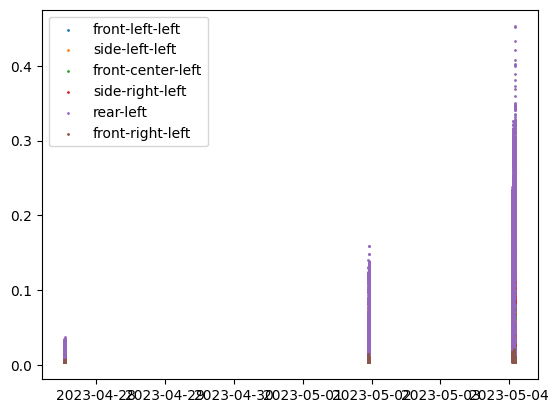

In [54]:
plot_seq(dust_df)

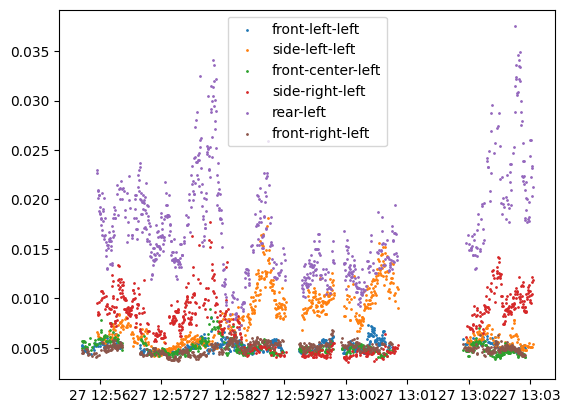

In [55]:
lo = datetime.datetime(2023, 4, 1)
hi = datetime.datetime(2023, 4, 27, 13, 5)
plot_seq(dust_df[(lo < dust_df['collected_on']) & (dust_df['collected_on'] < hi)])

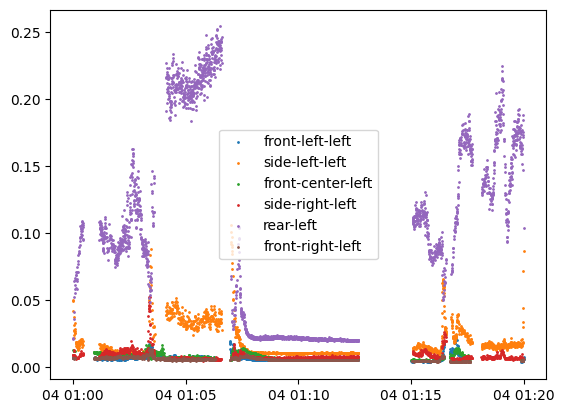

In [56]:
lo = datetime.datetime(2023, 5, 4, 1)
hi = datetime.datetime(2023, 5, 4, 1, 20)
plot_seq(dust_df[(lo < dust_df['collected_on']) & (dust_df['collected_on'] < hi)])

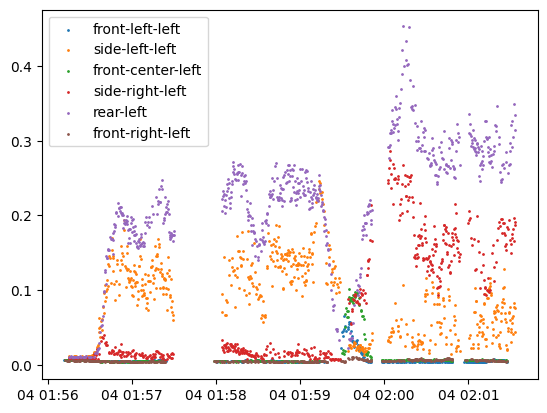

In [57]:
lo = datetime.datetime(2023, 5, 4, 1, 55)
hi = datetime.datetime(2023, 5,5)
plot_seq(dust_df[(lo < dust_df['collected_on']) & (dust_df['collected_on'] < hi)])